#### Initialization

In [49]:
exec(open("./divfuncs.py").read())

nrows=200
the_mod='llama_small'
the_api='pplx'

the_model=model_map[the_mod]
tpx_={'gpt':lambda x:get_topics_pplx(x,the_client=gpt4o_client,the_model='gpt-4o'),
      'pplx':lambda x:get_topics_pplx(x,the_model=the_model),
      'groq':lambda x:get_topics_groq(x)}[the_api]

##### Data collection

In [18]:
years=[2010,2013,2015,2018,2020,2023]

icmlpubs=[]
for the_year in years:
    print(the_year)
    icmlpubs.extend(get_publications_by_source(year=the_year,source_id="S4306419644"))
    
icmlpf=pd.DataFrame(icmlpubs)
icmlpf.to_csv("aaai_data/icml_2010_2013_2015_2018_2020_2023.csv")

2010
2013
2015
2018
2020
2023


  0%|          | 0/200 [00:00<?, ?it/s]

In [50]:
icmlsub_topics = (
    icmlpf.assign(num_citations=lambda x:x.cited_by_count.map(int),
                 abstract=lambda x:x.abstract_inverted_index.apply(decode_abstract))
    .groupby('publication_year', as_index=False)
    .apply(lambda x:x.sort_values('num_citations',ascending=False).head(200))
    .reset_index(drop=True)
).assign(topics=lambda x:tpx_(x['abstract']))

icmlpf2021=(
    pd.DataFrame(get_publications_by_source(year=2021,source_id="S4306419644"))
    .assign(abstract=lambda x:x.abstract_inverted_index.apply(decode_abstract))
)

icmlpf2021_sub200_topics=icmlpf2021.head(200).assign(topics=lambda x:tpx_(x['abstract']))

icmlsub_topics.to_csv("cached/icml_2010_2013_2015_2018_2020_2023_sub_topics.csv")

# Combining with 2021 pubs (2023 was strangely empty)
#######################################################
icmlpf2021=(
    pd.DataFrame(get_publications_by_source(year=2021,source_id="S4306419644"))
    .assign(abstract=lambda x:x.abstract_inverted_index.apply(decode_abstract))
)

icmlpf2021_sub200_topics=icmlpf2021.head(200).assign(topics=lambda x:tpx_(x['abstract']))

(
    pd.concat((icmlsub_topics,icmlpf2021_sub200_topics),axis=0)
    .to_csv("cached/icml_2010_2013_2015_2018_2020_2021_sub_topics.csv")
)

  0%|          | 0/943 [00:00<?, ?it/s]

In [78]:
icmlsub_topics=pd.read_csv("cached/icml_2010_2013_2015_2018_2020_2021_sub_topics.csv")

basedict={tmp:0 for tmp in icmlsub_topics.topics.unique()}
combined=pd.DataFrame([{**basedict,
                        **icmlsub_topics[icmlsub_topics.publication_year==tmp].groupby("topics").topics.count().to_dict()} 
                       for tmp in years[:-1]+[2021]])

# Figure out reasonable ordering of topics
tmp=combined.tail(1).T
tmp.columns=['n']
tops=tmp.sort_values('n',ascending=False).index
combined=combined[tops]

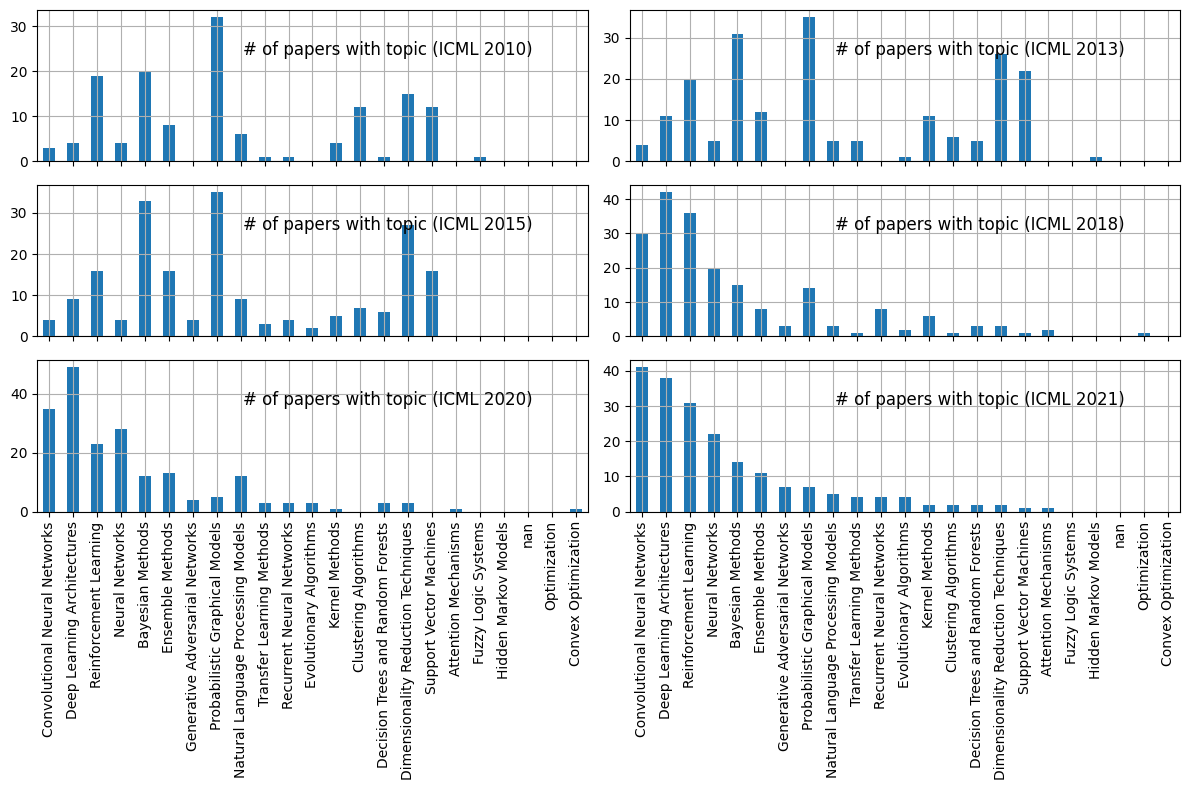

In [79]:
pl.figure(figsize=(12,8))
titles=['ICML 2010','ICML 2013', 'ICML 2015','ICML 2018','ICML 2020','ICML 2021']
i=1

for _,row in combined.iterrows():
  pl.subplot(3,2,i)
  row.plot(kind='bar')
  pl.grid(True)

  if i in (1,2,3,4):
    pl.gca().set_xticklabels([])

  pl.gca().set_title(f"# of papers with topic ({titles[i-1]})",loc='right',y=.65,x=.9)
  i+=1

pl.tight_layout()
pl.savefig("200topics.png")

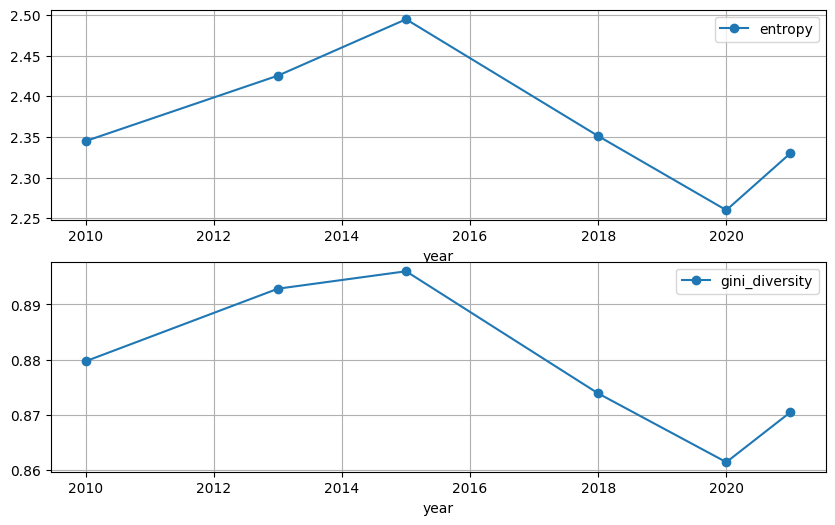

In [81]:
pl.figure(figsize=(10,6))

pl.subplot(2,1,1)
pd.DataFrame(zip((2010,2013,2015,2018,2020,2021),[(lambda x:np.sum([-tmp*np.log(tmp+np.finfo("float").eps) for tmp in x]))(tmp0[1])
 for tmp0 in (combined/combined.values.sum(axis=1).reshape((-1,1))).iterrows()]),
            columns=['year','entropy']).plot(x='year',y='entropy',marker='o',ax=pl.gca())
pl.grid(True)

pl.subplot(2,1,2)
pd.DataFrame(zip((2010,2013,2015,2018,2020,2021),
                 [(lambda x: 1-np.sum([tmp**2 for tmp in x]))
                  (tmp0[1]) for tmp0 in (combined/combined.values.sum(axis=1).reshape((-1,1))).iterrows()]),
            columns=['year','gini_diversity']).plot(x='year',y='gini_diversity',marker='o',ax=pl.gca())
pl.grid(True)

#### Analysis - AAAI

In [ ]:
## # Loading in the data

# Query openalex from the website, set source is Proceedings of the AAAI Conference on Artificial Intelligence, then year is <year>

pf2023=pd.read_csv("./aaai_data/works-2024-09-06T22-53-09_aaai_2023.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2020=pd.read_csv("./aaai_data/works-2024-09-06T21-59-15_aaai_2020.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2015=pd.read_csv("./aaai_data/works-2024-09-22T22-51-24_aaai_2015.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2010=pd.read_csv("./aaai_data/works-2024-09-06T22-01-39_aaai_2010.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2013=pd.read_csv("./aaai_data/works-2024-09-23T01-57-47_aaai_2013.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2018=pd.read_csv("./aaai_data/works-2024-09-23T01-59-00_aaai_2018.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))

pf2013.to_csv(f"cached/pf2013_{nrows}topics_{the_mod}.csv")
pf2018.to_csv(f"cached/pf2018_{nrows}topics_{the_mod}.csv")
pf2010.to_csv(f"cached/pf2010_{nrows}topics_{the_mod}.csv")
pf2015.to_csv(f"cached/pf2015_{nrows}topics_{the_mod}.csv")
pf2020.to_csv(f"cached/pf2020_{nrows}topics_{the_mod}.csv")
pf2023.to_csv(f"cached/pf2023_{nrows}topics_{the_mod}.csv")

#pf2010.topics.value_counts(),\
#pf2020.topics.value_counts(),\
#pf2023.topics.value_counts()

In [3]:
nrows=200
the_mod='llama_small'

the_model={"llama_small":"llama-3.1-8b-instruct",
           "llama_large":"llama-3.1-70b-instruct",
           "sonar_small":"llama-3.1-sonar-small-128k-chat",
           "sonar_large":"llama-3.1-sonar-large-128k-chat"}[the_mod]
tpx_={'gpt':lambda x:get_topics_pplx(x,the_client=gpt4o_client,the_model='gpt-4o'),
      'pplx':lambda x:get_topics_pplx(x,the_model=the_model),
      'groq':lambda x:get_topics_groq(x)}['pplx']

pf2013=pd.read_csv("./aaai_data/works-2024-09-23T01-57-47_aaai_2013.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))
pf2018=pd.read_csv("./aaai_data/works-2024-09-23T01-59-00_aaai_2018.csv").head(nrows).assign(topics=lambda x:tpx_(x.abstract))

pf2013.to_csv(f"cached/pf2013_{nrows}topics_{the_mod}.csv")
pf2018.to_csv(f"cached/pf2018_{nrows}topics_{the_mod}.csv")


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
load_cached=True
if load_cached:
  pf2010=pd.read_csv(f"cached/pf2010_{nrows}topics_{the_mod}.csv")
  pf2013=pd.read_csv(f"cached/pf2013_{nrows}topics_{the_mod}.csv")
  pf2015=pd.read_csv(f"cached/pf2015_{nrows}topics_{the_mod}.csv")
  pf2018=pd.read_csv(f"cached/pf2018_{nrows}topics_{the_mod}.csv")
  pf2020=pd.read_csv(f"cached/pf2020_{nrows}topics_{the_mod}.csv")
  pf2023=pd.read_csv(f"cached/pf2023_{nrows}topics_{the_mod}.csv")

result_dfs=[pf2010,pf2013,pf2015,pf2018,pf2020,pf2023]

basedict={tmp:0 for tmp in 
 reduce(lambda x,y:x.union(y),[set(tmp.topics) for tmp in result_dfs])
 if type(tmp)!=type(1.)}

combined=pd.DataFrame([{**basedict,**tmp.groupby("topics").topics.count().to_dict()} for tmp in result_dfs])

# Figure out reasonable ordering of topics
tmp=combined.tail(1).T
tmp.columns=['n']
tops=tmp.sort_values('n',ascending=False).index
combined=combined[tops]

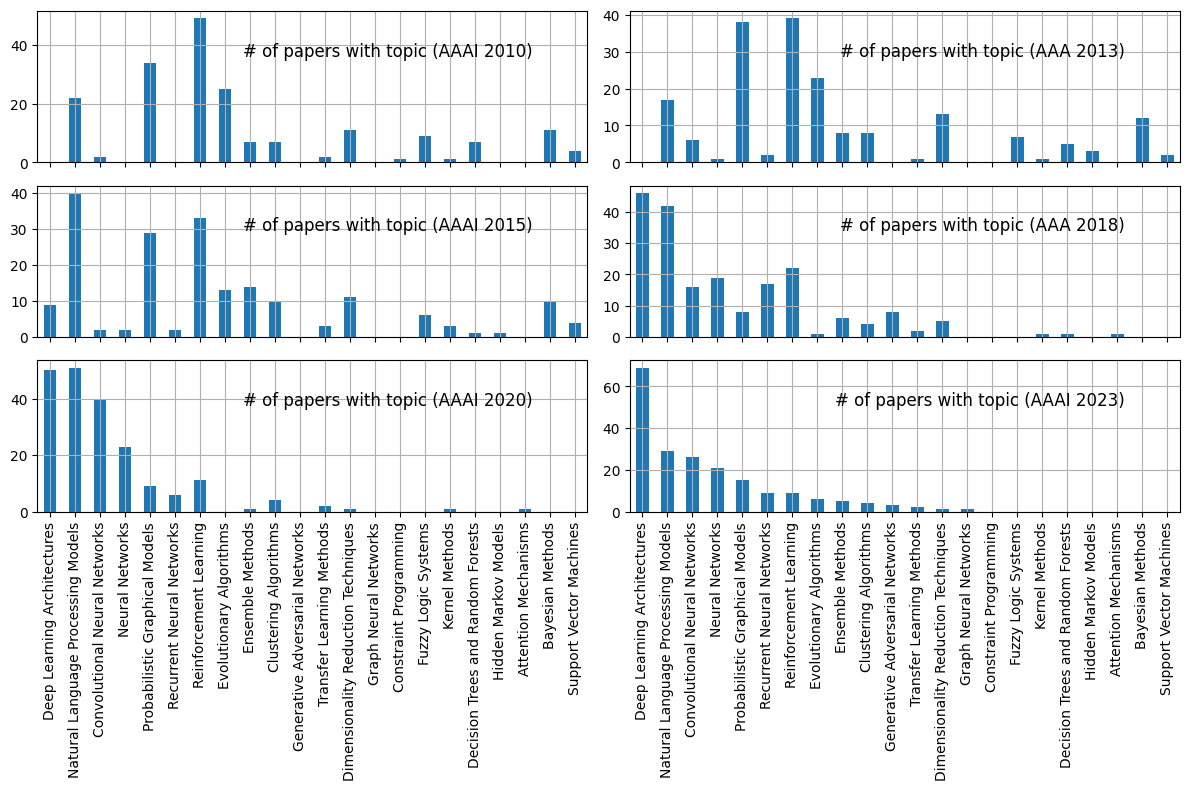

In [8]:
pl.figure(figsize=(12,8))
titles=['AAAI 2010','AAA 2013', 'AAAI 2015','AAA 2018','AAAI 2020','AAAI 2023']
i=1

for _,row in combined.iterrows():
  pl.subplot(3,2,i)
  row.plot(kind='bar')
  pl.grid(True)

  if i in (1,2,3,4):
    pl.gca().set_xticklabels([])

  pl.gca().set_title(f"# of papers with topic ({titles[i-1]})",loc='right',y=.65,x=.9)
  i+=1

pl.tight_layout()
pl.savefig("200topics.png")

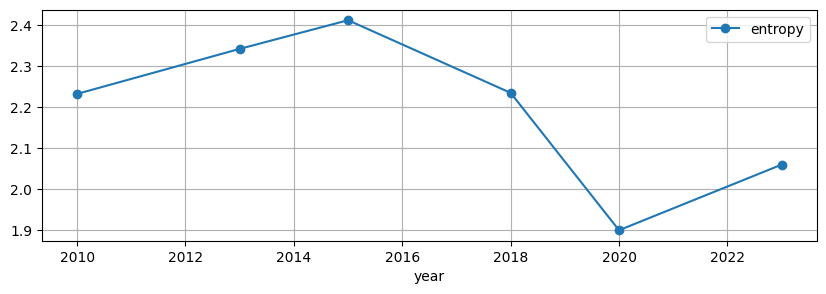

In [9]:
pl.figure(figsize=(10,3))
pd.DataFrame(zip((2010,2013,2015,2018,2020,2023),[(lambda x:np.sum([-tmp*np.log(tmp+np.finfo("float").eps) for tmp in x]))(tmp0[1])
 for tmp0 in (combined/combined.values.sum(axis=1).reshape((-1,1))).iterrows()]),
            columns=['year','entropy']).plot(x='year',y='entropy',marker='o',ax=pl.gca())
pl.grid(True)

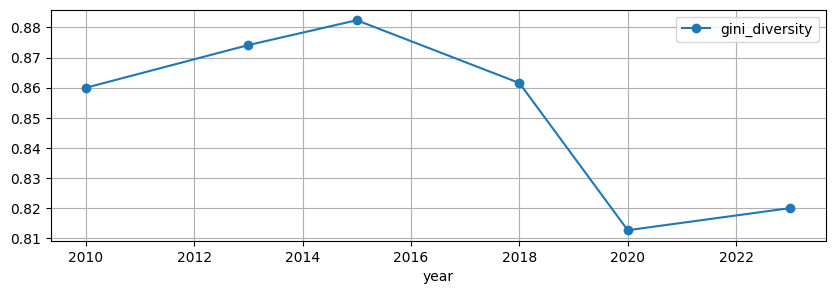

In [12]:
pl.figure(figsize=(10,3))
pd.DataFrame(zip((2010,2013,2015,2018,2020,2023),
                 [(lambda x: 1-np.sum([tmp**2 for tmp in x]))
                  (tmp0[1]) for tmp0 in (combined/combined.values.sum(axis=1).reshape((-1,1))).iterrows()]),
            columns=['year','gini_diversity']).plot(x='year',y='gini_diversity',marker='o',ax=pl.gca())
pl.grid(True)

## Scratch

In [35]:
### Older embedding messages:

def topic_extraction_msgs_older(passage):
  
  return [{'role':'system',
          'content':
          """
### You are a helpful assistant. Here are the instructions:

1. The user will provide a passage of text after these instructions.
2. Read the text and determine the main research domain or domains
Please limit the response to  domains selected from the following list:
    * Deep Learning
    * Neural Networks
    * Probabilistic methods
    * Agents
    * Decision Trees
    * Clustering
    * Visualization
    * Kernel methods

3. Provide the response in the form of a json object { "main_topic": topic_1, "secondary_topic": topic_2  }.
4. Again, remember to use ONLY topics provided in the list above. If NONE of them fit, you can fill in "N/A"
5. If there is only one matching topic, or if there is really only one main topic, set the "secondary_topic" to "N/A",   
6. ONLY provide the json response, with no additional comments or text. 

          """
          },
         {'role':'user',
          'content':f"""
### Here is the passage:

{passage}
          """
          }]

def topic_extraction_msgs_old(passage):

    return [{'role':'system',
          'content':
          """
### You are a helpful assistant. Here are the instructions:

1. The user will provide a passage of text after these instructions.
2. Read the text and determine the main research domain(s) from the following list:
    * Deep Learning
    * Neural Networks
    * Probabilistic methods
    * Agents
    * Decision Trees
    * Clustering
    * Visualization
    * Kernel methods

3. Provide the response in the form of a JSON object with the following structure:
   {
     "justification": "Brief explanation of why these topics were chosen",
     "main_topic": {"name": "topic_1", "confidence": 0.0-1.0},
     "secondary_topics": {"name": "topic_2", "confidence": 0.0-1.0}
   }

4. Use ONLY topics provided in the list above. If none fit, use "N/A"
5. Include up to two secondary topics if relevant, with a minimum confidence of 0.3.
6. Consider the overall context of the abstract, not just individual keywords.
7. Provide ONLY the JSON response, with no additional comments or text.
          """
          },
         {'role':'user',
          'content':f"""
### Here is the passage:

{passage}
          """
          }]


In [44]:
extract_topics(pf2020.abstract[0])

{'main_topic': 'N/A',
 'secondary_topic': 'N/A',
 'model': 'mistral-nemo:12b',
 'num_retries': -1}

In [107]:
# Sanity check
testf=pf2010.sample(2)
testf['topics']=testf['abstract'].map(lambda x:extract_topics(x,the_model='gemma2:9b-instruct-q5_1'))

pd.set_option('display.max_colwidth',None)
testf[['abstract','topics']]

,abstract,topics
32,"Auctions are promising decentralized methods for teams of agents to allocate and re-allocate tasks among themselves in dynamic, partially known and time-constrained domains with positive or negative synergies among tasks. Auction-based coordination systems are easy to understand, simple to implement and broadly applicable. They promise to be efficient both in communication (since agents communicate only essential summary information) and in computation (since agents compute their bids in parallel). Artificial intelligence research has explored auction-based coordination systems since the early work on contract networks, mostly from an experimental perspective. This overview paper describes our recent progress towards creating a framework for the design and analysis of cooperative auctions for agent coordination.","{'main_topic': {'name': 'Deep Learning', 'confidence': 0.8}, 'secondary_topic': 'N/A', 'model': 'gemma2:9b-instruct-q5_1', 'num_retries': 0}"
244,"In various domains, such as computer games, robotics, and transportation networks, shortest paths may need to be found quickly. Search time can be significantly reduced if it is known which parts of the graph include ``swamps''---areas that cannot lie on the only available shortest path, and can thus safely be pruned during search. We introduce an algorithm for detecting hierarchies of swamps, and exploiting them. Experiments support our claims of improved efficiency, showing significant reduction in search time.","{'main_topic': {'name': 'Agents', 'confidence': 0.8}, 'secondary_topic': 'N/A', 'model': 'gemma2:9b-instruct-q5_1', 'num_retries': 0}"


In [17]:
#res=pplx_client.chat.completions.create(model='llama-3.1-sonar-large-128k-chat',
#                                        messages=[{'role':'system','content':'you are a helpful assistant'},
#                                                  {'role':'user','content':'how are you doing'}])


res=pplx_client.chat.completions.create(model='llama-3.1-sonar-large-128k-chat',
                                        messages=topic_extraction_msgs('this is an abstract about neural networks'))

res.choices[0].message.content


'```json\n{\n  "justification": "The passage explicitly mentions \'neural networks\', which is a clear indicator of the main research domain.",\n  "main_topic": {"name": "Neural Networks", "confidence": 1.0},\n  "secondary_topics": {"name": "N/A", "confidence": 0.0}\n}\n```'

In [10]:
extract_topics(pf2020.abstract[1],
  client=pplx_client,the_model='llama-3.1-sonar-large-128k-chat')

{'main_topic': {'name': 'Agents', 'confidence': 0.9},
 'secondary_topic': 'N/A',
 'model': 'llama-3.1-sonar-large-128k-chat',
 'num_retries': 0}

In [11]:
get_topics_pplx(pf2020.abstract[:2])

  0%|          | 0/2 [00:00<?, ?it/s]

[{'main_topic': {'name': 'Agents', 'confidence': 0.9},
  'secondary_topic': 'N/A',
  'model': 'llama-3.1-sonar-large-128k-chat',
  'num_retries': 0},
 {'main_topic': {'name': 'Agents', 'confidence': 0.9},
  'secondary_topic': 'N/A',
  'model': 'llama-3.1-sonar-large-128k-chat',
  'num_retries': 0}]